<a href="https://colab.research.google.com/github/blufzzz/Introspective-Neural-Networks/blob/master/Introspective_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
from torch import nn
import torchvision
from torchvision.models import resnet18

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
model = resnet18(pretrained = True)
X = torch.randn(1,3,256,256)
model.forward(X).shape

torch.Size([1, 1000])

# INN Model

In [3]:
class Synthesis():
    def __init__(self, init_std=0.3, noise_grad_std=None):
        self.init_std = init_std;
        self.noise_grad_std = noise_grad_std;
        
    def sample(self, module, num_iter=10, learning_rate=1e-2):
        assert isinstance(module.X, torch.nn.Parameter), 'Expected X to be an instance of torch.nn.Parameter';
        
        # we do not want to create a graph and do backprop on net parameters, since we need only gradient of X
        for name, param in module.named_parameters():
            if name != 'X':
                param.requires_grad = False;
            else:
                param.requires_grad = True;
        
        module.X.data = module.X.data.normal_(mean=0, std=self.init_std);
        opt = torch.optim.SGD([module.X], lr=learning_rate);
        
        for i in range(num_iter):
            opt.zero_grad();
            classes = -module.to_synth();
            for j in range(classes.shape[0]):
                classes[j, ...].backward(retain_graph=True);
                
            if self.noise_grad_std is not None:
                module.X.data += torch.empty_like(module.X.data).normal_(mean=0, std=self.noise_grad_std);
            
            opt.step()
                
        return module.X.data;

In [7]:
class ICNN(nn.Module):
  
    def __init__(self, cnn_model, size, std=0.3, n_classes = False):
        super(ICNN, self).__init__()

        self.conv_features = [] # store conv_features for all passes
        self.model = cnn_model
        self.n_classes = n_classes
        self.sigmoid = nn.Sigmoid()
        self.model.fc = nn.Linear(in_features=512, out_features=1, bias=True)
        self.X = torch.nn.Parameter(torch.empty(size).normal_(mean=0, std=std));
        self.X.requires_grad = False;

    def forward(self, input, sigmoid = False):

        hook = lambda module, input, output: self.conv_features.append(output)
        self.model.avgpool.register_forward_hook(hook)
        output = self.model.forward(input)

        return self.sigmoid(output)

    def to_synth(self):

        hook = lambda module, input, output: self.conv_features.append(output)
        self.model.avgpool.register_forward_hook(hook)

        return self.model.forward(self.X)

In [40]:
X = torch.randn(2,3,28,28)
icnn_model = ICNN(model, X.size())
s = Synthesis(init_std=0.3);
result = s.sample(icnn_model, num_iter=100, learning_rate=1e-1)

In [10]:
result.shape

torch.Size([2, 3, 28, 28])

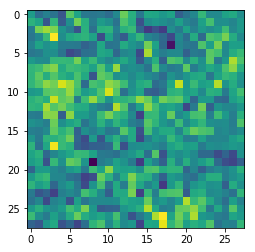

In [19]:
plt.imshow(result[0,0,:,:])

# Wasserstein loss

In [35]:
batch_size = 16
n=5
X = torch.randn(5, 3, 28, 28)
y = torch.FloatTensor(n).random_(2)*2-1
X_1 = X[y==1]
X_2 = X[y==-1]

In [36]:
batch_1 = X_1[torch.LongTensor(batch_size).random_(len(X_1))]
batch_2 = X_2[torch.LongTensor(batch_size).random_(len(X_2))]
alphas = torch.FloatTensor(batch_size).uniform_(0,1)
batch_hat = torch.zeros_like(batch_1)
for i in range(batch_size):
    batch_hat.data[i]=batch_1[i]*alphas[i]+batch_2[i]*(1-alphas[i])

batch_hat.requires_grad=True

In [37]:
batch_1.shape

torch.Size([16, 3, 28, 28])

In [38]:
icnn_model=ICNN(model, 28)
f_1 = icnn_model.forward(batch_1, sigmoid=False)
f_2 = icnn_model.forward(batch_2, sigmoid=False)
f_hat = icnn_model.forward(batch_hat, sigmoid=False)

In [39]:
grads_hat = []
for i in range(batch_size):
    grads_hat.append(torch.autograd.grad(f_hat[i],batch_hat, retain_graph=True, create_graph=True)[0][i])

In [40]:
loss = 0
for i in range(batch_size):
    loss+=f_2[i]-f_1[i]+torch.norm(grads_hat[i], p=2)

loss/=batch_size

In [44]:
loss.backward()

In [47]:
batch_hat.grad

tensor([[[[-2.1712e-02, -1.7547e-02, -1.8942e-02,  ..., -1.5337e-04,
            3.9389e-03,  1.7153e-02],
          [-1.6219e-02, -1.3494e-02, -9.2888e-03,  ...,  3.8582e-03,
            1.6926e-02,  2.1994e-02],
          [-1.2152e-02, -3.5706e-02, -1.5613e-02,  ...,  1.2475e-03,
            2.2685e-02,  1.9318e-02],
          ...,
          [-2.2066e-03, -1.7533e-03, -9.1930e-03,  ..., -8.3438e-03,
            6.2283e-03,  7.4102e-03],
          [ 8.4026e-04,  5.9306e-03,  7.7647e-04,  ...,  4.0104e-04,
            1.0580e-04, -1.2138e-04],
          [-1.0150e-03,  2.6919e-03, -2.6827e-03,  ..., -3.6125e-03,
           -2.7064e-03, -7.5866e-04]],

         [[-1.4734e-02, -5.7910e-03, -8.7223e-03,  ..., -2.1010e-03,
            6.8506e-03,  2.1643e-02],
          [-2.0200e-03,  5.4632e-03,  1.3889e-02,  ...,  3.8225e-04,
            2.3421e-02,  2.9531e-02],
          [ 1.5607e-03, -2.3448e-02,  7.0876e-03,  ..., -2.8234e-03,
            2.9180e-02,  2.5814e-02],
          ...,
     

In [45]:
grads_hat[0]

tensor([[[-0.0014,  0.0038, -0.0285,  ...,  0.0055,  0.0092,  0.0409],
         [ 0.0825, -0.0396, -0.0958,  ...,  0.0291,  0.0400,  0.0566],
         [ 0.0707, -0.0153,  0.0150,  ...,  0.0073,  0.0498,  0.0488],
         ...,
         [ 0.0162,  0.0507, -0.0272,  ...,  0.0118, -0.0101, -0.0255],
         [ 0.0182,  0.0239, -0.0291,  ..., -0.0006,  0.0166,  0.0101],
         [ 0.0022,  0.0027, -0.0081,  ..., -0.0098,  0.0071,  0.0187]],

        [[ 0.0016, -0.0060, -0.0679,  ...,  0.0201,  0.0299,  0.0595],
         [ 0.1076, -0.0416, -0.1257,  ...,  0.0441,  0.0709,  0.0869],
         [ 0.0734, -0.0142,  0.0231,  ...,  0.0064,  0.0756,  0.0806],
         ...,
         [ 0.0304,  0.0689, -0.0186,  ...,  0.0243,  0.0465,  0.0254],
         [ 0.0262,  0.0270, -0.0247,  ...,  0.0068,  0.0514,  0.0411],
         [ 0.0069,  0.0028, -0.0002,  ..., -0.0166,  0.0259,  0.0377]],

        [[ 0.0080,  0.0247, -0.0029,  ...,  0.0141,  0.0143,  0.0278],
         [ 0.0872,  0.0229, -0.0207,  ...,  0

In [46]:
grads_hat[0].grad